https://www.youtube.com/watch?v=ISNdQcPhsts

全体像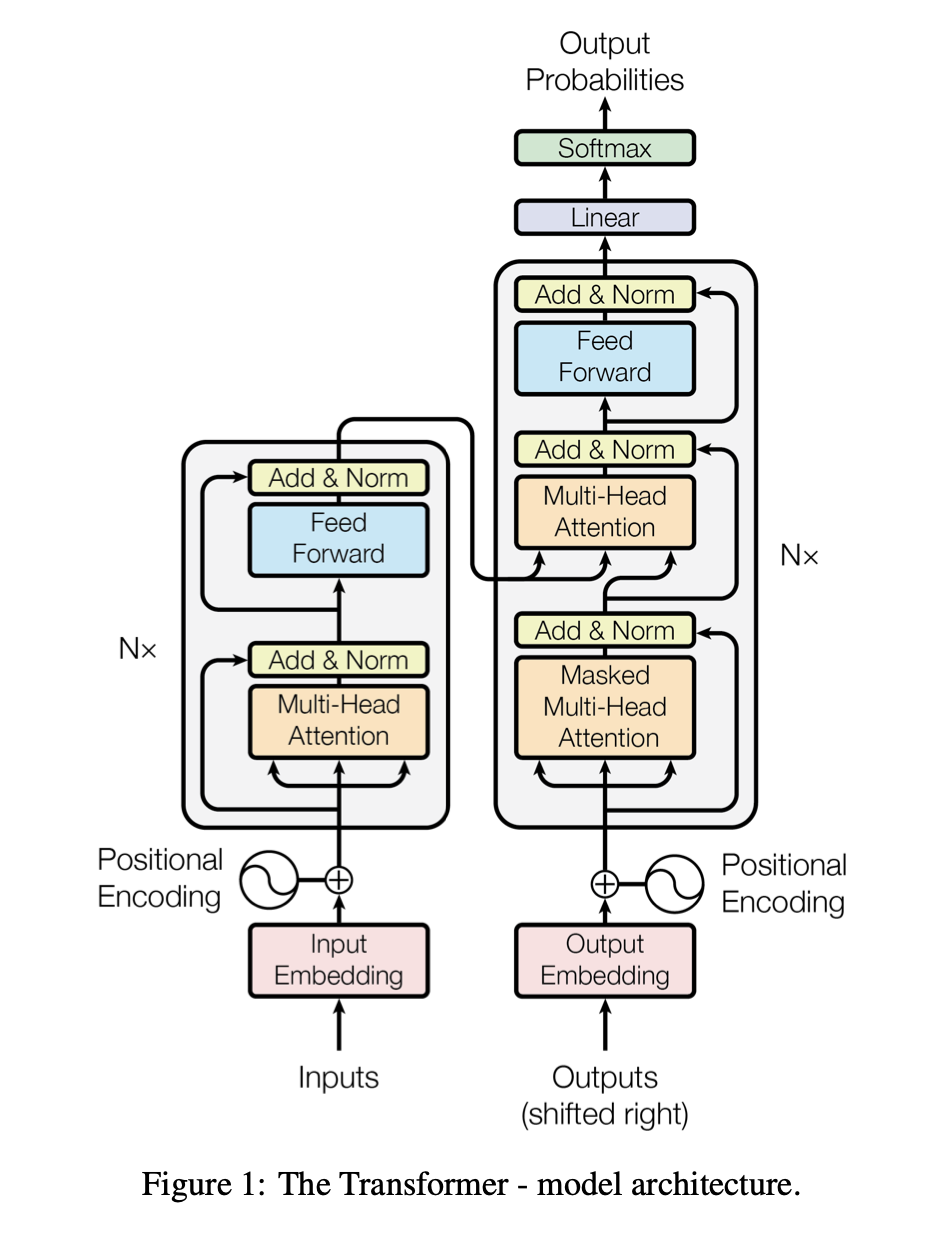


In [19]:
import torch
import torch.nn as nn
import math

入力埋め込みと位置エンコーディング


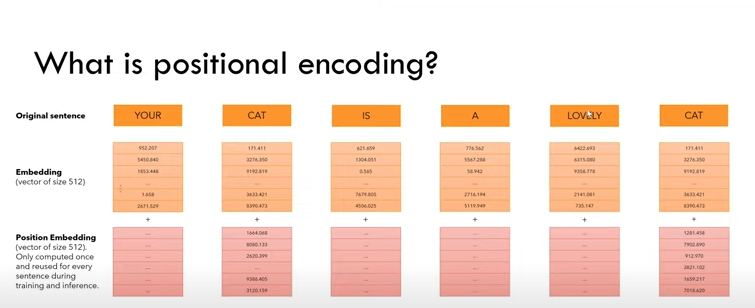

入力埋め込み:スケールは分散1にするために人工的にかけてる(パイトーチの設定)

```
# これはコードとして書式設定されます
```



In [3]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)

In [5]:
# パラメータ設定
d_model = 512
vocab_size = 1000
batch_size = 32
seq_len = 10

# テストケース生成
input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))
embedding_layer = InputEmbeddings(d_model, vocab_size)#.to(device)

In [9]:
# テンソル直接確認
print(f"input_ids shape: {input_ids.shape}")  # torch.Size([batch_size, sequence_length])

input_ids shape: torch.Size([32, 10])


In [6]:
embedding_layer

InputEmbeddings(
  (embedding): Embedding(1000, 512)
)

確かに、単語数に対して512行のベクトルになっている。

In [11]:
embedding_layer(input_ids).shape

torch.Size([32, 10, 512])

ポジショナルエンコーディング　単語数✖️512

In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

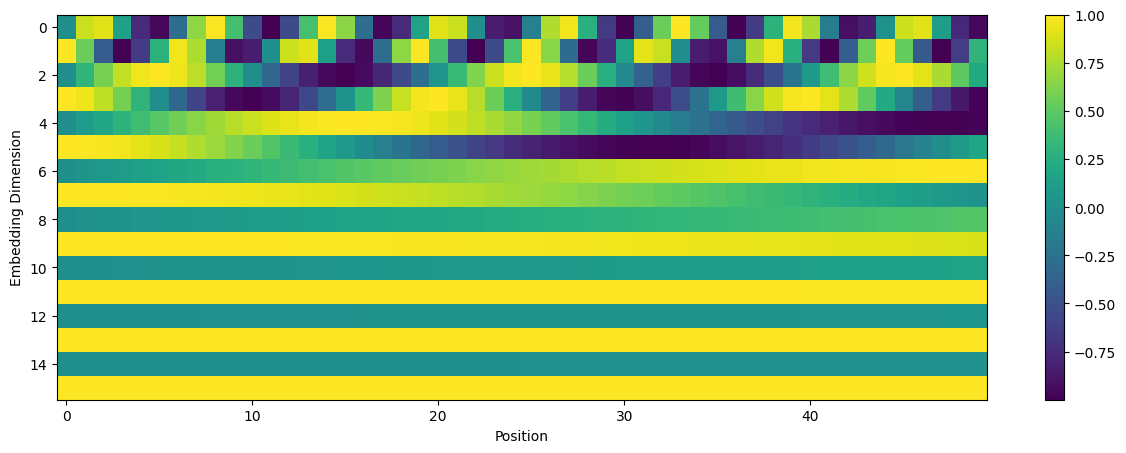

In [14]:
# PositionalEncodingクラスのインスタンス化が必要
d_model = 16  # テスト用に小さな次元を設定
seq_len = 50
dropout = 0.1

# 1. クラスインスタンスを作成
pos_encoder = PositionalEncoding(d_model, seq_len, dropout)

# 2. バッファからPEを取得
pe = pos_encoder.pe  # 登録されたバッファにアクセス

# 3. 可視化実行
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.imshow(pe.squeeze().T, cmap='viridis', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Embedding Dimension')
plt.colorbar()
plt.show()


ポイント**位置の相対的違いがわかる**
位置エンコーディングの仕組みを、画像の具体的な特徴から説明します。

## 位置の識別方法
### 上部（0-4次元）の特徴
- 市松模様のような細かい周期パターン
- 紫（-1）と黄（+1）が頻繁に入れ替わる
- **近い位置の区別**に有効
  - 例：Position 1と2の違いが明確に現れる

### 中部（5-8次元）の特徴
- より緩やかな周期変化
- 黄色と青緑の帯が徐々に変化
- **中距離の位置関係**を表現
  - 例：Position 10と20の違いがはっきり見える

### 下部（9-15次元）の特徴
- 非常に長い周期のパターン
- 黄色と青緑の帯が広く分布
- **遠い位置の区別**に効果的
  - 例：Position 0と40の大きな違いを表現

## 具体的な位置の特定方法
各位置（縦一列）は、以下の組み合わせで一意に特定できます：
1. 上部の細かいパターン（局所的な位置）
2. 中部の中程度の変化（中距離の位置）
3. 下部の緩やかな変化（大域的な位置）

これにより、どの位置も固有の「指紋」のようなパターンを持ち、モデルはこれを使って位置を認識します。

## 実践的な例
Position 10の位置を特定する場合：
1. 上部：特定の市松模様パターン
2. 中部：特定の緑がかった領域
3. 下部：黄色と青緑の特定の組み合わせ

この3つの特徴の組み合わせが、Position 10を他のすべての位置と区別する固有の情報となります。

Citations:
[1] https://pplx-res.cloudinary.com/image/upload/v1738629726/user_uploads/whWidNErrmZcWrN/image.jpg

足し算しても、(Ei+Pi ) *(Ej+Pj) みたいな感じの内積計算をするので、位置情報はPiPj部分で残る

入力形状: torch.Size([32, 10])
埋め込み後の形状: torch.Size([32, 10, 512])
位置エンコーディング後の形状: torch.Size([32, 10, 512])


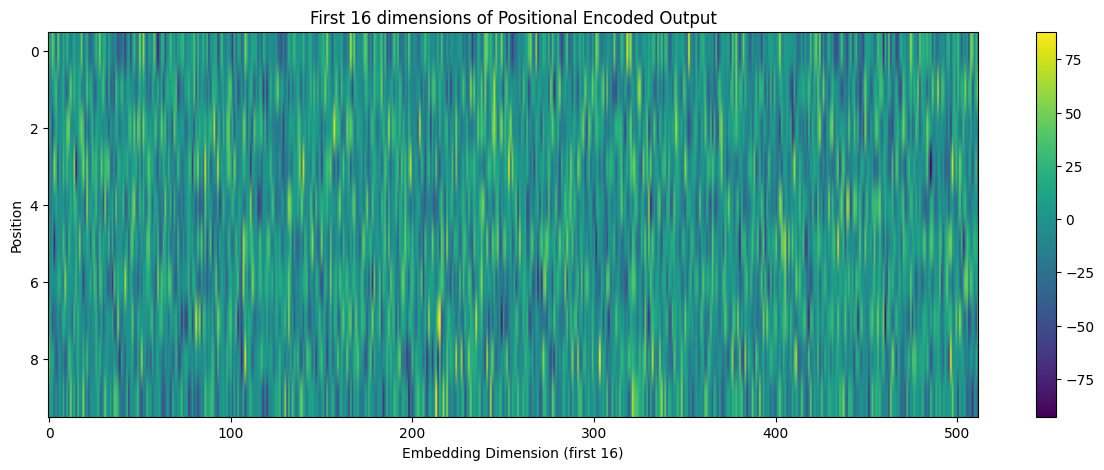

In [16]:
d_model = 512
vocab_size = 1000
batch_size = 32
seq_len = 10
dropout = 0.1

# モデルのインスタンス化
embedding_layer = InputEmbeddings(d_model, vocab_size)
pos_encoder = PositionalEncoding(d_model, seq_len, dropout)

# テストデータの生成と処理
input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))
embedded = embedding_layer(input_ids)
encoded = pos_encoder(embedded)

# 結果の確認
print(f"入力形状: {input_ids.shape}")  # [32, 10]
print(f"埋め込み後の形状: {embedded.shape}")  # [32, 10, 512]
print(f"位置エンコーディング後の形状: {encoded.shape}")  # [32, 10, 512]

# 可視化（最初のバッチの最初の16次元を表示）
plt.figure(figsize=(15, 5))
plt.imshow(encoded[0, :, :].detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Embedding Dimension (first 16)')
plt.ylabel('Position')
plt.title('First 16 dimensions of Positional Encoded Output')
plt.show()

Layer Normalization:学習安定化のために用いられている

In [17]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

正規化出力ができている　Add Norm のところで使う

平均値の平均: -0.0000
標準偏差の平均: 1.0000


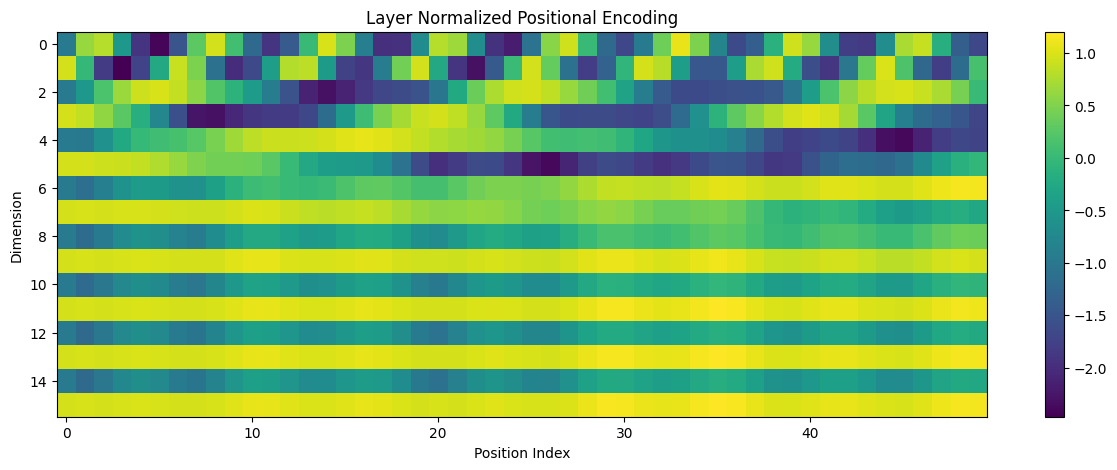

In [18]:
d_model = 16
seq_len = 50
dropout = 0.1

# 1. 位置エンコーダのインスタンス化
pos_encoder = PositionalEncoding(d_model, seq_len, dropout)

# 2. 位置エンコーディング取得
pe = pos_encoder.pe.squeeze()  # [50, 16]

# 3. レイヤー正規化適用
layer_norm = LayerNormalization(d_model)
norm_pe = layer_norm(pe)  # [50, 16]

# 統計量計算
mean_values = norm_pe.mean(dim=1)
std_values = norm_pe.std(dim=1)

print(f"平均値の平均: {mean_values.mean().item():.4f}")
print(f"標準偏差の平均: {std_values.mean().item():.4f}")

# 可視化
plt.figure(figsize=(15, 5))
plt.imshow(norm_pe.detach().numpy().T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Position Index')
plt.ylabel('Dimension')
plt.title('Layer Normalized Positional Encoding')
plt.show()

Feed Forward

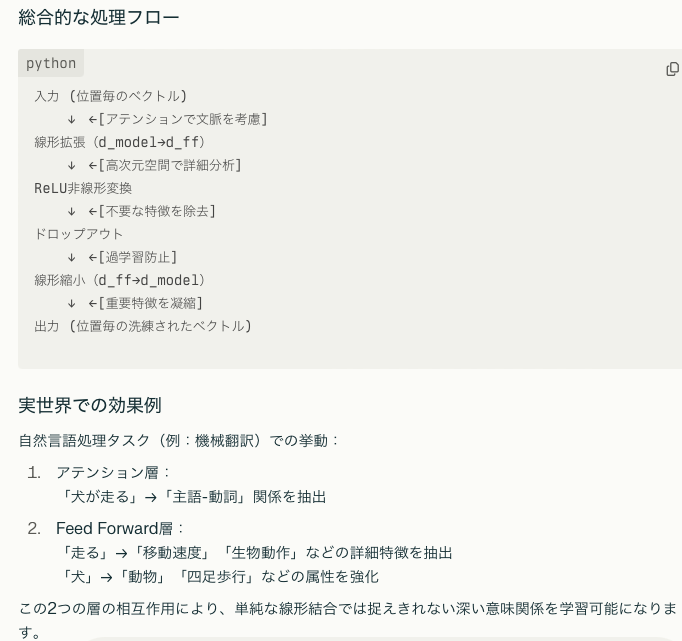

入力次元: (batch, seq, d_model)
       ↓ linear1
隠れ層次元: (batch, seq, d_ff)
       ↓ ReLU + Dropout
       ↓ linear2
出力次元: (batch, seq, d_model)


In [22]:
# パラメータ例
d_model = 512
d_ff = 2048
batch_size = 32
seq_len = 100

# 入力テンソル
x = torch.randn(batch_size, seq_len, d_model)  # (32, 100, 512)
print(x.shape)
# 第1線形層
linear_1 = nn.Linear(d_model, d_ff)  # 512 → 2048
h = linear_1(x)  # (32, 100, 2048)
print(h.shape)
# 活性化関数
h = torch.relu(h)  # 非線形変換

# ドロップアウト
h = nn.Dropout(0.1)(h)  # ランダムに10%をゼロ化

# 第2線形層
linear_2 = nn.Linear(d_ff, d_model)  # 2048 → 512
output = linear_2(h)  # (32, 100, 512)
print(output.shape)

torch.Size([32, 100, 512])
torch.Size([32, 100, 2048])
torch.Size([32, 100, 512])


同じ形で帰ってくる

In [23]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


入力テンソル形状: torch.Size([4, 10, 16])
出力テンソル形状: torch.Size([4, 10, 16])
入力テンソルの平均: 0.0176, 標準偏差: 0.9816
出力テンソルの平均: -0.0276, 標準偏差: 0.2600


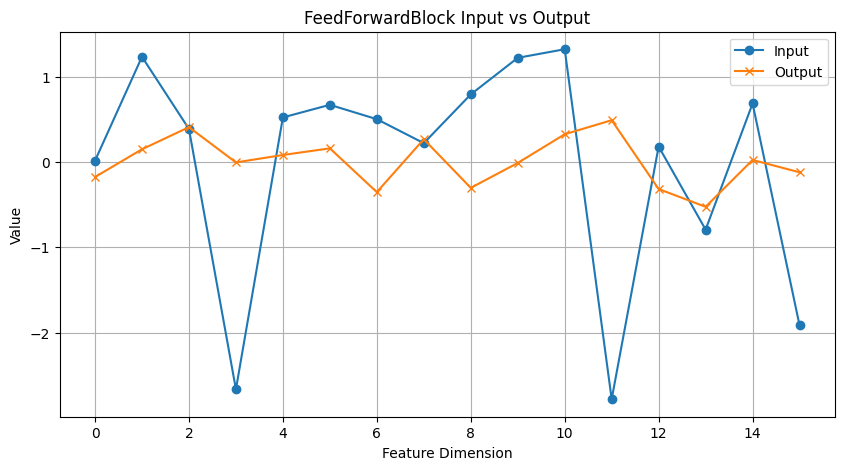

In [24]:

# パラメータ設定
d_model = 16  # 入力次元
d_ff = 64     # 中間次元（拡張次元）
dropout = 0.1 # ドロップアウト率
batch_size = 4
seq_len = 10

# FeedForwardBlockインスタンス化
ff_block = FeedForwardBlock(d_model=d_model, d_ff=d_ff, dropout=dropout)

# 入力テンソル作成（ランダム値）
input_tensor = torch.randn(batch_size, seq_len, d_model)  # (4, 10, 16)

# FeedForwardBlockを通した出力
output_tensor = ff_block(input_tensor)

# 結果確認
print(f"入力テンソル形状: {input_tensor.shape}")   # (4, 10, 16)
print(f"出力テンソル形状: {output_tensor.shape}") # (4, 10, 16)

# 入力と出力の統計情報
print(f"入力テンソルの平均: {input_tensor.mean().item():.4f}, 標準偏差: {input_tensor.std().item():.4f}")
print(f"出力テンソルの平均: {output_tensor.mean().item():.4f}, 標準偏差: {output_tensor.std().item():.4f}")

# 可視化（最初のバッチの先頭位置ベクトルをプロット）
plt.figure(figsize=(10, 5))
plt.plot(range(d_model), input_tensor[0, 0].detach().numpy(), label="Input", marker='o')
plt.plot(range(d_model), output_tensor[0, 0].detach().numpy(), label="Output", marker='x')
plt.xlabel("Feature Dimension")
plt.ylabel("Value")
plt.title("FeedForwardBlock Input vs Output")
plt.legend()
plt.grid()
plt.show()

マルチヘッドアテンション
512次元の意味ベクトルをdk次元に分割する
分割した中でQとKでアテンション付けてコンテキストにする。これをくっつけた後に回す(Wo)
マスクはソフトマックスの時の値を小さくすることで実質見なくさせられる(アテンションが向かない)


マルチヘッドアテンションの次元変換を具体的な数値例と図解で説明します。各操作でテンソルがどのように変形されるかを段階的に追います。

```python
# パラメータ設定例
batch_size = 2
seq_len = 5   # 単語数
d_model = 16  # 特徴量次元
h = 4         # ヘッド数
d_k = d_model // h = 4  # ヘッド毎の次元
```

## 処理フローの詳細

### 1. 初期入力
```python
# 入力テンソル (バッチ, シーケンス長, 特徴量次元)
q = torch.randn(batch_size, seq_len, d_model)  # (2,5,16)
k = torch.randn(batch_size, seq_len, d_model)
v = torch.randn(batch_size, seq_len, d_model)
```

### 2. 線形変換（Wq/Wk/Wv適用）
```python
query = self.w_q(q)  # (2,5,16) → (2,5,16)
key = self.w_k(k)    # (2,5,16) → (2,5,16)
value = self.w_v(v)  # (2,5,16) → (2,5,16)
```

### 3. ヘッド分割（queryの処理を例に）
```python
# viewによる形状変更：バッチ、シーケンス長、ヘッド数、ヘッド次元
query = query.view(2,5,4,4)  # (2,5,4,4)
# 次元順序変更：バッチ、ヘッド数、シーケンス長、ヘッド次元
query = query.transpose(1,2)  # (2,4,5,4)
```

#### 次元変換のイメージ
```
Before view: [バッチ][シーケンス][全特徴量]
            (2,5,16) = 2×5×16
After view: [バッチ][シーケンス][ヘッド数][ヘッド次元]
          (2,5,4,4) = 2×5×4×4
After transpose: [バッチ][ヘッド数][シーケンス][ヘッド次元]
               (2,4,5,4)
```

### 4. アテンション計算
```python
# (2,4,5,4) @ (2,4,4,5) → (2,4,5,5)
attention_scores = (query @ key.transpose(-2,-1)) / sqrt(4)
```

#### アテンションスコアの構造
```
各ヘッド毎のアテンションマップ:
ヘッド1: 5x5行列（単語間の関連度）
ヘッド2: 5x5行列
ヘッド3: 5x5行列
ヘッド4: 5x5行列
```

### 5. ヘッド結合処理
```python
# 入力形状: (2,4,5,4)
x = x.transpose(1,2)  # (2,5,4,4)
x = x.contiguous().view(2,5,16)  # (2,5,16)
```

#### 結合プロセス
```
各ヘッドの出力をシーケンス方向に並べて結合:
[[ヘッド1次元0, ヘッド1次元1, ..., ヘッド4次元3]]
→ 4ヘッド×4次元=16次元に復元
```

## 次元変化の可視化

### 入力から出力までの変化
```
入力 q: (2,5,16)
↓ Wq適用
query: (2,5,16)
↓ ヘッド分割 & 転置
query: (2,4,5,4)
↓ アテンション計算
attention_scores: (2,4,5,5)
↓ 値との積
x: (2,4,5,4)
↓ ヘッド結合
x: (2,5,16)
↓ Wo適用
出力: (2,5,16)
```

## なぜviewとtransposeが必要か？

1. **並列処理の効率化**:
   ```python
   # ヘッドを別次元に分離 → 並列計算可能
   # 元の形状: (2,5,16) → 分割後: (2,4,5,4)
   ```

2. **ヘッド間の独立性確保**:
   ```python
   # 各ヘッドが独立した特徴空間で動作
   # 例: ヘッド1 → 文法構造, ヘッド2 → 意味関係
   ```

3. **GPUメモリ効率**:
   ```python
   # 連続したメモリ配置を維持（contiguous()で保証）
   # view操作の前にtransposeで次元を整理
   ```

## 具体例で見るview操作
### 元のqueryテンソル
```
インデックス: [0,0,0,0] → 最初のバッチ、最初の単語、全16次元
値: [0.1, 0.2, 0.3, ..., 1.6]
```

### view適用後
```
4次元に分割:
[0.1,0.2,0.3,0.4],  # ヘッド1
[0.5,0.6,0.7,0.8],  # ヘッド2
[0.9,1.0,1.1,1.2],  # ヘッド3
[1.3,1.4,1.5,1.6]   # ヘッド4
```

### transpose後
```
各ヘッドが独立した次元に:
ヘッド1: [0.1,0.2,0.3,0.4]
ヘッド2: [0.5,0.6,0.7,0.8]
...
```

## マスク処理の視覚化例
```python
# シーケンス長3のマスク
mask = [
    [1,0,0],
    [1,1,0],
    [1,1,1]
]

# アテンションスコア例
[
    [8.2, 1.5, 0.3],
    [0.9, 7.1, 0.5],
    [1.2, 0.8, 6.4]
]

# マスク適用後
[
    [8.2, -1e9, -1e9],
    [0.9, 7.1, -1e9],
    [1.2, 0.8, 6.4]
]

# Softmax後
[
    [1.0, 0.0, 0.0],
    [0.1, 0.9, 0.0],
    [0.1, 0.1, 0.8]
]
```

この構造により、Transformerは複数の視点（ヘッド）から同時に単語間の関係を分析し、効率的に重要な特徴を抽出できます。viewとtransposeの操作は、この並列処理を実現するための次元再編成として機能しています。

In [31]:
q = torch.randn(batch_size, seq_len, d_model)  # (2,5,16)class MultiHeadAttentionBlock(nn.Module):
  def __init__(self,d_model:int,h:int,dropout:float) -> None:

      super().__init__()
      self.d_model = d_model # Embedding vector size
      self.h = h # Number of heads
      # Make sure d_model is divisible by h
      assert d_model % h == 0, "d_model is not divisible by h"

      self.d_k = d_model // h # Dimension of vector seen by each head
      self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
      self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
      self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
      self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
      self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
      d_k = query.shape[-1]
      # Just apply the formula from the paper
      # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
      attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
      if mask is not None:
          # Write a very low value (indicating -inf) to the positions where mask == 0
          attention_scores.masked_fill_(mask == 0, -1e9)
      attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
      if dropout is not None:
          attention_scores = dropout(attention_scores)
      # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
      # return attention scores which can be used for visualization
      return (attention_scores @ value), attention_scores

  def forward(self, q, k, v, mask):
      query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
      key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
      value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

      # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
      query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
      key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
      value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

      # Calculate attention
      x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

      # Combine all the heads together
      # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
      x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

      # Multiply by Wo
      # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
      return self.w_o(x)


In [26]:
# パラメータ例
d_model = 512  # 埋め込み次元
h = 8          # アテンションヘッド数
d_k = d_model // h   # ヘッドごとの次元
batch_size = 4
seq_len = 10   # 入力シーケンス長


入力形状: torch.Size([4, 10, 512])
出力形状: torch.Size([4, 10, 512])


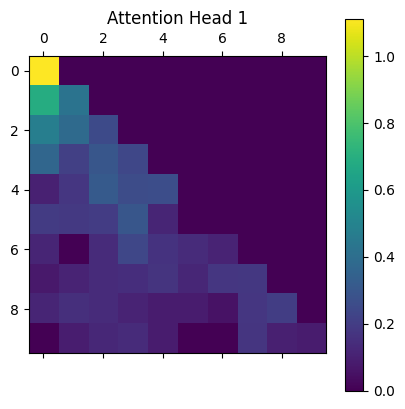

In [32]:
# テストパラメータ
d_model = 512
h = 8
d_k = d_model // h
batch_size = 4
seq_len = 10

# テスト入力
q = torch.randn(batch_size, seq_len, d_model)
k = torch.randn(batch_size, seq_len, d_model)
v = torch.randn(batch_size, seq_len, d_model)

# マスク例（未来情報防止）
mask = torch.tril(torch.ones(seq_len, seq_len))  # 下三角行列

# モジュール初期化
mha = MultiHeadAttentionBlock(d_model, h, dropout=0.1)

# 実行
output = mha(q, k, v, mask)

# 次元確認
print(f"入力形状: {q.shape}")
print(f"出力形状: {output.shape}")  # (4,10,512) を確認

# アテンションスコアの可視化（最初のバッチ、最初のヘッド）
plt.matshow(mha.attention_scores[0,0].detach().numpy())
plt.title("Attention Head 1")
plt.colorbar()
plt.show()


Resdual Connection

In [33]:
class ResidualConnection(nn.Module):

        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)

        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

ここまでの機能を組み合わせたエンコーダー

In [36]:
class EncoderBlock(nn.Module):
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x


In [37]:


# テストパラメータ
d_model = 512
h = 8
d_ff = 2048
dropout = 0.1
batch_size = 4
seq_len = 10

# コンポーネント初期化
self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
feed_forward = FeedForwardBlock(d_model, d_ff, dropout)
encoder_block = EncoderBlock(d_model, self_attn, feed_forward, dropout)

# テスト入力
x = torch.randn(batch_size, seq_len, d_model)
src_mask = torch.ones(seq_len, seq_len)  # マスク（全て許可）

# フォワードパス
output = encoder_block(x, src_mask)

# 検証ポイント
print(f"入力形状: {x.shape}")  # torch.Size([4, 10, 512])
print(f"出力形状: {output.shape}")  # torch.Size([4, 10, 512])

# 出力値の範囲確認
print(f"出力最小値: {output.min().item():.4f}")
print(f"出力最大値: {output.max().item():.4f}")

# 勾配計算テスト
output.sum().backward()
print("勾配計算が正常に完了")

# 残差接続検証
input_norm = torch.norm(x)
output_norm = torch.norm(output)
print(f"入力ノルム: {input_norm:.4f}")
print(f"出力ノルム: {output_norm:.4f}")
assert output_norm > input_norm, "適切な変換が行われているか確認"


入力形状: torch.Size([4, 10, 512])
出力形状: torch.Size([4, 10, 512])
出力最小値: -4.1909
出力最大値: 4.4382
勾配計算が正常に完了
入力ノルム: 143.0213
出力ノルム: 148.8265


複数繰り返す

In [38]:
class Encoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers  # 複数のEncoderBlock
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)  # 層を積み重ね
        return self.norm(x)     # 最終出力を正規化


In [39]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

次単語予測のための確率分布を取得するためのプロジェクション

In [40]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return torch.logsoftmax(self.proj(x),dim=-1)


In [41]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

In [42]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

     # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

Tokenizer :単語に分割する
言語ごとの設定

In [44]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [46]:
import torch
import torch.nn as nn
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path

In [ ]:
def get_all_sentenfes(ds,lang):
  for item in ds[lang]:
    yield item["translation"][lang]

In [ ]:
def get_or_build_tokenizer(config,ds,lang):
  #config["tokenizer_file"] = "../tokenizers/tokenizer_{0}.json"
  tokenizer_path = Path(config["tokenizer_file"].format(lang))
  if not Path.exists(tokenizer_path):
    tokenizer = Tokenizer(WordLevelTrainer(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]",min_frequency=2])
    tokenizer.train_from_iterator(get_all_sentenfes(ds,lang), trainer=trainer)
    tokenizer.save(str(tokenizer_path))

    else:
      tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer



In [ ]:
def get_ds(conig):
  ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')
  # Build tokenizers
  tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
  tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

  # Keep 90% for training, 10% for validation
  train_ds_size = int(0.9 * len(ds_raw))
  val_ds_size = len(ds_raw) - train_ds_size
  train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

  train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
  val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

  # Find the maximum length of each sentence in the source and target sentence
  max_len_src = 0
  max_len_tgt = 0

  for item in ds_raw:
      src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
      tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
      max_len_src = max(max_len_src, len(src_ids))
      max_len_tgt = max(max_len_tgt, len(tgt_ids))

  print(f'Max length of source sentence: {max_len_src}')
  print(f'Max length of target sentence: {max_len_tgt}')

  train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
  val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

  return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt


データセット

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

トレーニングループ :計算がきつい婆はヘッド数やレイヤー数を減らす(パフォーマンスには影響ある)

In [56]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

Pytorch の互換性のところでエラー出てる!!

In [57]:
#from model import build_transformer
#from dataset import BilingualDataset, causal_mask
#from config import get_config, get_weights_file_path, latest_weights_file_path

import torchtext.datasets as datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR

import warnings
from tqdm import tqdm
import os
from pathlib import Path

# Huggingface datasets and tokenizers
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

import torchmetrics
from torch.utils.tensorboard import SummaryWriter

OSError: /usr/local/lib/python3.11/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [49]:
def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'])
    return model



In [ ]:
def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    else:
        print("NOTE: If you have a GPU, consider using it for training.")
        print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
        print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

     # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

     for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:
          encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
          decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
          encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
          decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

          # Run the tensors through the encoder, decoder and the projection layer
          encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
          decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
          proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

          # Compare the output with the label
          label = batch['label'].to(device) # (B, seq_len)

          # Compute the loss using a simple cross entropy
          loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
          batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

           # Log the loss
          writer.add_scalar('train loss', loss.item(), global_step)
          writer.flush()

          # Backpropagate the loss
          loss.backward()

          # Update the weights
          optimizer.step()
          optimizer.zero_grad(set_to_none=True)

          global_step += 1


        # Run validation at the end of every epoch
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)


Config

In [50]:
def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)